In [2]:
import os
import pandas as pd

FS_PATH = "FlowScore"

files = [f for f in os.listdir(FS_PATH) if f.endswith(".csv")]

print("총 파일:", len(files))

column_summary = {}

for fname in files:
    path = os.path.join(FS_PATH, fname)
    try:
        df = pd.read_csv(path, nrows=5)  # 로딩 빠르게
        cols = df.columns.tolist()
        column_summary[fname] = cols
        print(f"\n==== {fname} ====")
        print(cols)
    except Exception as e:
        print(f"\n[로드 실패] {fname} → {e}")


총 파일: 38

==== business.csv ====
['id', 'name', 'representative_name', 'business_number', 'created_at', 'updated_at', 'enabled']

==== business_invitation.csv ====
['id', 'inviter_email', 'invitee_email', 'link_uuid', 'created_at', 'expired_at', 'invitee_name', 'status', 'enabled']

==== company.csv ====
['id', 'business_number', 'corporate_number', 'company_name', 'representative_name', 'company_status_code', 'company_size', 'business_category_code', 'business_category_name', 'establishment_date', 'location_zip_code', 'location_address', 'road_name_zip_code', 'road_name_address', 'telephone_number', 'email', 'created_at', 'updated_at', 'enabled']

==== company_capital_status.csv ====
['id', 'company_id', 'created_at', 'base_dt', 'chg_dt', 'reg_dt', 'dp_am', 'w_iss_stk_t_cn', 'iss_stk_t_cn', 'cstk_cn', 'pstk_cn', 'etc_stk_cn', 't_am']

==== company_cash_flow.csv ====
['id', 'company_id', 'created_at', 'cf_acct_dt', 'cf_anal1', 'cf_anal2', 'cf_anal3', 'cf_anal4']

==== company_credit_gr

In [4]:
import os
import pandas as pd

FS_PATH = "FlowScore"

# -----------------------------------------------------------------------------
# 1) 회사 마스터 로드 + brn_key 생성
# -----------------------------------------------------------------------------
company = pd.read_csv(os.path.join(FS_PATH, "company.csv"))

# 사업자번호 정제
company["brn_key"] = (
    company["business_number"]
    .astype(str)
    .str.replace(r"[^0-9]", "", regex=True)
)

# 인벤토리 기본 틀 (company_id 단위)
inventory = company[["id", "company_name", "brn_key", "establishment_date", "company_status_code"]].copy()
inventory = inventory.rename(columns={"id": "company_id"})

# -----------------------------------------------------------------------------
# 2) 테이블별 company_id 당 row 수 카운트
#    (필요한 테이블만 골라서)
# -----------------------------------------------------------------------------
tables = {
    # 재무
    "fs_bs"        : "company_financial_statement.csv",
    "fs_is"        : "company_income_statement.csv",
    "fs_status"    : "financial_status.csv",
    "fs_ratio"     : "company_financial_ratio.csv",
    "cash_flow"    : "company_cash_flow.csv",
    # 비재무 / 신용
    "emp_stats"    : "company_employee_statistics.csv",
    "pension_emp"  : "company_pension_employee_statistics.csv",
    "history"      : "company_history.csv",
    "cap_status"   : "company_capital_status.csv",
    "credit_grade" : "company_credit_grade.csv",
    "moratorium"   : "company_moratorium.csv",
    "overdue"      : "company_overdue.csv",
    "overview"     : "company_overview.csv",
    "rep"          : "company_representative.csv",
    "rep_hist"     : "company_representative_history.csv",
    "stockholder"  : "company_stockholder.csv",
    "exec"         : "company_executives.csv",
    "exec_detail"  : "company_executive_detail.csv",
    "ewa_grade"    : "ewa_grade.csv",
}

for short_name, fname in tables.items():
    path = os.path.join(FS_PATH, fname)
    if not os.path.exists(path):
        print(f"[WARN] {fname} 없음, 건너뜀")
        continue

    try:
        # company_id만 있으면 되므로 최소 컬럼만 로드
        df = pd.read_csv(path, usecols=["company_id"])
    except ValueError:
        # 혹시 company_id가 없으면 스킵
        print(f"[WARN] {fname} 에 company_id 컬럼이 없음, 스킵")
        continue

    cnt = (
        df.groupby("company_id")
          .size()
          .rename(f"{short_name}_rows")
          .reset_index()
    )

    inventory = inventory.merge(cnt, on="company_id", how="left")

# NaN → 0 으로 (데이터가 없다는 의미)
row_cols = [c for c in inventory.columns if c.endswith("_rows")]
inventory[row_cols] = inventory[row_cols].fillna(0).astype(int)

# -----------------------------------------------------------------------------
# 3) 핵심 커버리지 플래그 만들기 (True/False)
# -----------------------------------------------------------------------------
inventory["has_bs"]         = inventory["fs_bs_rows"]        > 0
inventory["has_is"]         = inventory["fs_is_rows"]        > 0
inventory["has_fin_status"] = inventory["fs_status_rows"]    > 0
inventory["has_fin_ratio"]  = inventory["fs_ratio_rows"]     > 0

# "재무모형 가능" : BS + IS 둘 다 있고, 상태/비율 중 하나라도 있으면 True
inventory["core_fin_ok"] = (
    inventory["has_bs"]
    & inventory["has_is"]
)

# 비재무 기본 (직원수 + 회사요약 + 히스토리 중 하나라도)
inventory["has_emp"]   = inventory["emp_stats_rows"] > 0
inventory["has_hist"]  = inventory["history_rows"]   > 0
inventory["has_overview"] = inventory["overview_rows"] > 0
inventory["nonfin_basic_ok"] = (
    inventory["has_emp"]
    | inventory["has_hist"]
    | inventory["has_overview"]
)

# 신용/연체 관련
inventory["has_overdue"]     = inventory["overdue_rows"] > 0
inventory["has_moratorium"]  = inventory["moratorium_rows"] > 0
inventory["has_credit_grade"]= inventory["credit_grade_rows"] > 0

# -----------------------------------------------------------------------------
# 4) 간단 요약 출력
# -----------------------------------------------------------------------------
n_companies = len(inventory)
print(f"총 기업 수: {n_companies}")

def coverage(col_flag: str, label: str):
    if col_flag not in inventory.columns:
        return
    ratio = inventory[col_flag].mean() * 100
    print(f"- {label}: {ratio:.1f}% 기업이 데이터 보유")

coverage("core_fin_ok", "핵심 재무 데이터(BS+IS) 존재")
coverage("nonfin_basic_ok", "비재무 기본 데이터(직원/히스토리/오버뷰) 중 1개 이상 존재")
coverage("has_overdue", "연체 이력 데이터 존재")
coverage("has_moratorium", "모라토리움 데이터 존재")
coverage("has_credit_grade", "신용등급 데이터 존재")

# -----------------------------------------------------------------------------
# 5) CSV로 저장
# -----------------------------------------------------------------------------
out_path = os.path.join(FS_PATH, "FlowScore_Data_Inventory.csv")
inventory.to_csv(out_path, index=False, encoding="utf-8-sig")
print(f"\n✅ 인벤토리 저장 완료: {out_path}")


총 기업 수: 765
- 핵심 재무 데이터(BS+IS) 존재: 75.9% 기업이 데이터 보유
- 비재무 기본 데이터(직원/히스토리/오버뷰) 중 1개 이상 존재: 97.8% 기업이 데이터 보유
- 연체 이력 데이터 존재: 1.0% 기업이 데이터 보유
- 모라토리움 데이터 존재: 86.5% 기업이 데이터 보유
- 신용등급 데이터 존재: 80.0% 기업이 데이터 보유

✅ 인벤토리 저장 완료: FlowScore\FlowScore_Data_Inventory.csv


In [6]:
import os
import csv

FP_PATH = "FlowPoint"  # FlowPoint 폴더 경로

file_list = os.listdir(FP_PATH)

for f in file_list:
    if f.endswith(".csv"):
        path = os.path.join(FP_PATH, f)
        try:
            with open(path, "r", encoding="utf-8") as fp:
                reader = csv.reader(fp)
                header = next(reader)  # 첫 줄만 읽기
            print(f"\n==== {f} ====")
            print(header)
        except Exception as e:
            print(f"\n==== {f} ====")
            print(f"⚠️ 헤더 읽기 실패: {e}")



==== accounts.csv ====
['id', 'created_at', 'updated_at', 'deleted_at', 'user_id', 'category', 'bank_code', 'account_number', 'account_owner', 'registration_number', 'company_id']

==== assignments.csv ====
['id', 'created_at', 'updated_at', 'deleted_at', 'user_id', 'assignee_user_id', 'amount', 'remain_amount', 'category', 'state', 'apply_date', 'cancel_date', 'done_date', 'cancel_message', 'assignee_business_registration_number', 'assignee_company_name', 'assignee_email', 'assignee_address', 'assignee_address_detail', 'assignee_ceo_name', 'assignee_zipcode', 'assignee_phone1', 'assignee_phone2', 'assignee_phone3', 'note', 'is_signed', 'company_id']

==== assignment_add_docs.csv ====
['id', 'created_at', 'deleted_at', 'user_id', 'category', 'is_signed']

==== assignment_assignment_add_docs.csv ====
['assignment_id', 'assignment_add_doc_id']

==== assignment_assignment_details.csv ====
['assignment_id', 'assignment_detail_id']

==== assignment_details.csv ====
['id', 'created_at', 'up

In [1]:
import pandas as pd
import numpy as np
import os

# ==============================================================================
# 1. 환경 설정 및 데이터 로드
# ==============================================================================
PATH_SCORE = './FlowScore/'
PATH_POINT = './FlowPoint/'

def load_csv(folder, filename):
    path = os.path.join(folder, filename)
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            # 컬럼명 공백 제거
            df.columns = [c.strip() for c in df.columns]
            return df
        except Exception as e:
            print(f"❌ 파일 로드 에러 ({filename}): {e}")
            return pd.DataFrame()
    else:
        print(f"⚠️ 파일 없음: {filename}")
        return pd.DataFrame()

print("🚀 FlowPoint 핵심 데이터 확대 로딩 및 검증 시작...\n")

# [FlowPoint 핵심 데이터 로드]
df_trans   = load_csv(PATH_POINT, 'receivable_transactions.csv')      # 1. 거래 내역
df_ceo     = load_csv(PATH_POINT, 'pay_bnpl_customer_infos_b2c.csv')  # 2. 대표자 신용
df_css     = load_csv(PATH_POINT, 'business_css_infos.csv')           # 3. 기업 외부 등급
df_receiv  = load_csv(PATH_POINT, 'receivables.csv')                  # 4. 매출채권 원장
df_reqs    = load_csv(PATH_POINT, 'pay_bnpl_requests.csv')            # (매핑용) 요청 정보

# [FlowScore 기본 데이터 (비교군)]
df_comp    = load_csv(PATH_SCORE, 'company.csv')

# ==============================================================================
# 2. 데이터 구조 및 연결 고리(Join Key) 확인
# ==============================================================================
print("\n📊 [데이터 구조 진단]")

def check_structure(df, name, key_candidates):
    if df.empty:
        print(f"❌ {name}: 데이터 없음")
        return
    
    found_keys = [k for k in key_candidates if k in df.columns]
    print(f"✅ {name}: 총 {len(df)}건")
    print(f"   - 식별 키(Keys): {found_keys}")
    print(f"   - 주요 컬럼: {list(df.columns[:5])} ...")

# 각 테이블별 핵심 키 컬럼 존재 여부 확인
check_structure(df_trans, "거래 내역 (Transactions)", ['company_id', 'company_id_tx', 'receivable_id', 'id'])
check_structure(df_ceo, "대표자 신용 (CEO Credit)", ['pay_bnpl_request_id', 'id', 'credit_score'])
check_structure(df_css, "기업 신용 (Biz Grade)", ['company_id', 'business_registration_number'])
check_structure(df_receiv, "매출채권 원장 (Receivables)", ['id', 'company_id', 'due_date'])

# ==============================================================================
# 3. 데이터 충실도(Sufficiency) 정밀 분석
# ==============================================================================
print("\n📊 [데이터 충실도 분석]")

# (1) 거래 내역: 16시 이후 결제 데이터 가용성
if not df_trans.empty and 'created_at' in df_trans.columns:
    df_trans['created_at'] = pd.to_datetime(df_trans['created_at'], errors='coerce')
    valid_time = df_trans['created_at'].notnull().sum()
    print(f"📌 [자금흐름] 결제 시간 데이터: {valid_time}건 유효 ({valid_time/len(df_trans)*100:.1f}%)")
else:
    print("⚠️ [자금흐름] 결제 시간(created_at) 컬럼 없음")

# (2) 대표자 신용: 신용점수 분포 확인
if not df_ceo.empty and 'credit_score' in df_ceo.columns:
    valid_score = df_ceo[df_ceo['credit_score'] > 0]['credit_score'].count()
    print(f"📌 [대표신용] 유효 신용점수(>0): {valid_score}건 ({valid_score/len(df_ceo)*100:.1f}%)")
    if valid_score > 0:
        print(f"   - 평균 점수: {df_ceo['credit_score'].mean():.1f}점")
else:
    print("⚠️ [대표신용] 신용점수(credit_score) 컬럼 없음")

# (3) 기업 등급: 외부 등급 보유율
if not df_css.empty and 'total_score' in df_css.columns:
    valid_grade = df_css['total_score'].notnull().sum()
    print(f"📌 [기업등급] 외부 평가 점수: {valid_grade}건 보유")
else:
    print("⚠️ [기업등급] 종합점수(total_score) 컬럼 없음")

# (4) 결제 지연 분석 가능성 (Transactions + Receivables 조인)
if not df_trans.empty and not df_receiv.empty:
    # 조인 시도 (키 컬럼 추정)
    tx_key = 'receivable_id' if 'receivable_id' in df_trans.columns else 'id' # Trans 테이블의 FK
    rc_key = 'id' # Receivables 테이블의 PK
    
    # 실제 조인 가능한지 테스트
    # (주의: 컬럼명이 다를 수 있으므로 확인 필요. 보통 Trans에 receivable_id가 있어야 함)
    if 'receivable_id' in df_trans.columns:
        matched = df_trans[df_trans['receivable_id'].isin(df_receiv['id'])]
        print(f"📌 [지연분석] 거래-원장 매칭 성공: {len(matched)}건 (전체 거래의 {len(matched)/len(df_trans)*100:.1f}%)")
    else:
        print("⚠️ [지연분석] Transaction 테이블에 'receivable_id' 컬럼이 없어 매칭 불가")

print("\n🚀 1단계 검증 완료. 이 결과를 바탕으로 지표 산출 여부를 결정합니다.")

🚀 FlowPoint 핵심 데이터 확대 로딩 및 검증 시작...


📊 [데이터 구조 진단]
✅ 거래 내역 (Transactions): 총 24698건
   - 식별 키(Keys): ['company_id', 'id']
   - 주요 컬럼: ['id', 'created_at', 'updated_at', 'deleted_at', 'user_id'] ...
✅ 대표자 신용 (CEO Credit): 총 6건
   - 식별 키(Keys): ['id', 'credit_score']
   - 주요 컬럼: ['id', 'created_at', 'updated_at', 'deleted_at', 'company_id'] ...
✅ 기업 신용 (Biz Grade): 총 1751건
   - 식별 키(Keys): ['company_id', 'business_registration_number']
   - 주요 컬럼: ['id', 'created_at', 'updated_at', 'deleted_at', 'business_user_id'] ...
✅ 매출채권 원장 (Receivables): 총 14421건
   - 식별 키(Keys): ['id', 'company_id', 'due_date']
   - 주요 컬럼: ['id', 'created_at', 'updated_at', 'deleted_at', 'user_id'] ...

📊 [데이터 충실도 분석]
📌 [자금흐름] 결제 시간 데이터: 24698건 유효 (100.0%)
📌 [대표신용] 유효 신용점수(>0): 6건 (100.0%)
   - 평균 점수: 861.2점
📌 [기업등급] 외부 평가 점수: 1751건 보유
⚠️ [지연분석] Transaction 테이블에 'receivable_id' 컬럼이 없어 매칭 불가

🚀 1단계 검증 완료. 이 결과를 바탕으로 지표 산출 여부를 결정합니다.


In [3]:
import pandas as pd
import numpy as np
import os

# ==============================================================================
# 1. 설정 및 데이터 로드
# ==============================================================================
PATH_SCORE = './FlowScore/'
PATH_POINT = './FlowPoint/'

def load_csv(folder, filename):
    path = os.path.join(folder, filename)
    if os.path.exists(path):
        try:
            df = pd.read_csv(path)
            df.columns = [c.strip() for c in df.columns]
            return df
        except: return pd.DataFrame()
    return pd.DataFrame()

print("🚀 FlowScore 3.0: 승인 기업 모니터링 대시보드 생성 시작...")

# [FlowScore: 재무 데이터]
df_fin = load_csv(PATH_SCORE, 'company_financial_statement.csv')
df_inc = load_csv(PATH_SCORE, 'company_income_statement.csv')
df_comp = load_csv(PATH_SCORE, 'company.csv')

# [FlowPoint: 활동 및 신용 데이터]
df_rcv_trans = load_csv(PATH_POINT, 'receivable_transactions.csv') # 자금 흐름 패턴용
df_trans = load_csv(PATH_POINT, 'transactions.csv') # 결제 지연 분석용
df_receiv = load_csv(PATH_POINT, 'receivables.csv') # 매출채권 원장
df_ceo = load_csv(PATH_POINT, 'pay_bnpl_customer_infos_b2c.csv') # CEO 신용
df_css = load_csv(PATH_POINT, 'business_css_infos.csv') # 기업 등급

# ==============================================================================
# 2. 지표 산출 (Metrics Calculation)
# ==============================================================================
dashboard_data = {} # Company_ID -> Dict

# ------------------------------------------------------------------------------
# (1) 재무 건전성 (Financial Health)
# ------------------------------------------------------------------------------
print("📊 1. 재무 지표 계산 중...")
if not df_fin.empty:
    df_fin['fs_acct_dt'] = pd.to_datetime(df_fin['fs_acct_dt'])
    # 최신 데이터 추출
    fin_latest = df_fin.sort_values('fs_acct_dt').groupby('company_id').tail(1).set_index('company_id')
    
    for cid, row in fin_latest.iterrows():
        # 유동비율
        curr_ratio = row.get('fs_val2', 0) / row.get('fs_val238', 1) if row.get('fs_val238', 0) > 0 else 0
        # 부채비율
        debt_ratio = row.get('fs_val237', 0) / row.get('fs_val317', 1) * 100 if row.get('fs_val317', 0) > 0 else 0
        
        dashboard_data.setdefault(cid, {})['Current_Ratio'] = curr_ratio
        dashboard_data[cid]['Debt_Ratio'] = debt_ratio

# ------------------------------------------------------------------------------
# (2) 자금 흐름 패턴 (Cash Flow Pattern) - Late Payment
# ------------------------------------------------------------------------------
print("📊 2. 자금 흐름(오후결제) 분석 중...")
if not df_rcv_trans.empty:
    df_rcv_trans['created_at'] = pd.to_datetime(df_rcv_trans['created_at'])
    df_rcv_trans['hour'] = df_rcv_trans['created_at'].dt.hour
    
    # company_id 확인
    cid_col = 'company_id' if 'company_id' in df_rcv_trans.columns else ('company_id_tx' if 'company_id_tx' in df_rcv_trans.columns else None)
    
    if cid_col:
        tx_stats = df_rcv_trans.groupby(cid_col).agg(
            total=('id', 'count'),
            late=('hour', lambda x: (x >= 16).sum())
        )
        tx_stats['Late_Pay_Ratio'] = tx_stats['late'] / tx_stats['total']
        
        for cid, row in tx_stats.iterrows():
            dashboard_data.setdefault(cid, {})['Late_Pay_Ratio'] = row['Late_Pay_Ratio']
            dashboard_data[cid]['Tx_Count'] = row['total']

# ------------------------------------------------------------------------------
# (3) 지급 지연 (Payment Delay) - [수정됨]
# ------------------------------------------------------------------------------
print("📊 3. 지급 지연(Delay) 분석 중...")
delay_calculated = False
if not df_trans.empty and not df_receiv.empty:
    # 1. Key 매칭
    if 'receivable_id' in df_trans.columns and 'id' in df_receiv.columns:
        # 날짜 변환
        df_receiv['due_date'] = pd.to_datetime(df_receiv['due_date'])
        df_trans['created_at'] = pd.to_datetime(df_trans['created_at']) # 실제 결제일
        
        # 2. 병합 (Merge)
        # suffixes=('_tx', '_rcv') 설정으로 중복 컬럼명 충돌 방지
        merged = pd.merge(df_trans, df_receiv, left_on='receivable_id', right_on='id', suffixes=('_tx', '_rcv'))
        
        # 3. 지연일수 계산 (수정된 컬럼명 사용)
        # created_at -> created_at_tx (거래 발생일 = 결제일)
        # due_date -> due_date_rcv (또는 due_date가 겹치지 않았다면 그대로 due_date)
        
        pay_date_col = 'created_at_tx' if 'created_at_tx' in merged.columns else 'created_at'
        due_date_col = 'due_date_rcv' if 'due_date_rcv' in merged.columns else 'due_date'
        
        if pay_date_col in merged.columns and due_date_col in merged.columns:
            merged['delay_days'] = (merged[pay_date_col] - merged[due_date_col]).dt.days
            
            # company_id 확보 (receivables 기준)
            comp_col = 'company_id_rcv' if 'company_id_rcv' in merged.columns else 'company_id'
            
            if comp_col in merged.columns:
                delay_stats = merged.groupby(comp_col)['delay_days'].mean()
                for cid, delay in delay_stats.items():
                    dashboard_data.setdefault(cid, {})['Avg_Delay_Days'] = delay
                delay_calculated = True
                print(f"   ✅ 거래-원장 매칭 성공 ({len(merged)}건)")
            else:
                print("   ⚠️ 병합 데이터에서 Company ID를 찾을 수 없습니다.")
        else:
            print(f"   ⚠️ 날짜 컬럼 매칭 실패: {pay_date_col}, {due_date_col} 확인 필요")

if not delay_calculated:
    print("   ℹ️ 지급 지연 분석 생략 (데이터 매칭 불가)")

# ------------------------------------------------------------------------------
# (4) 신용 등급 (Credit)
# ------------------------------------------------------------------------------
print("📊 4. 신용 등급 매핑 중...")
if not df_css.empty and 'total_score' in df_css.columns:
    for _, row in df_css.iterrows():
        cid = row.get('company_id')
        if pd.notnull(cid):
            dashboard_data.setdefault(cid, {})['Biz_Score'] = row['total_score']

if not df_ceo.empty and 'credit_score' in df_ceo.columns:
    if 'company_id' in df_ceo.columns:
        for _, row in df_ceo.iterrows():
            cid = row.get('company_id')
            if pd.notnull(cid):
                dashboard_data.setdefault(cid, {})['CEO_Score'] = row['credit_score']

# ==============================================================================
# 3. 리포트 생성 및 저장
# ==============================================================================
results = []
for cid, metrics in dashboard_data.items():
    # 기업명
    comp_name = f"ID {cid}"
    if not df_comp.empty:
        match = df_comp[df_comp['id'] == cid]['company_name']
        if not match.empty: comp_name = match.values[0]
    
    # 리스크 판정 (Monitoring Alerts)
    alerts = []
    
    # 재무
    cr = metrics.get('Current_Ratio', 99)
    dr = metrics.get('Debt_Ratio', 0)
    if cr <= 1.0 and 'Current_Ratio' in metrics: alerts.append("유동성주의")
    if dr >= 300: alerts.append("부채과다")
    
    # 활동
    lpr = metrics.get('Late_Pay_Ratio', 0)
    delay = metrics.get('Avg_Delay_Days', 0)
    if lpr >= 0.2: alerts.append(f"오후결제({lpr*100:.0f}%)")
    if delay >= 5: alerts.append(f"결제지연({delay:.1f}일)")
    
    # 신용
    biz_score = metrics.get('Biz_Score', 0)
    ceo_score = metrics.get('CEO_Score', 0)
    if 0 < biz_score < 50: alerts.append("기업신용저하")
    if 0 < ceo_score < 700: alerts.append("CEO신용저하")

    risk_cnt = len(alerts)
    if risk_cnt == 0: grade = 'Normal'
    elif risk_cnt == 1: grade = 'Watch'
    elif risk_cnt == 2: grade = 'Warning'
    else: grade = 'Danger'

    row = {
        'Company_ID': cid,
        'Company_Name': comp_name,
        'Grade': grade,
        'Risk_Signals': ", ".join(alerts) if alerts else "-",
        'Late_Pay_Ratio': f"{lpr*100:.1f}%" if 'Late_Pay_Ratio' in metrics else "-",
        'Avg_Delay_Days': f"{delay:.1f}일" if 'Avg_Delay_Days' in metrics else "-",
        'Current_Ratio': f"{cr:.2f}" if 'Current_Ratio' in metrics else "-",
        'Biz_Score': biz_score if 'Biz_Score' in metrics else "-",
        'CEO_Score': ceo_score if 'CEO_Score' in metrics else "-",
        'Tx_Count': metrics.get('Tx_Count', 0)
    }
    results.append(row)

df_report = pd.DataFrame(results)

if not df_report.empty:
    # 정렬: 위험도 순
    df_report['Risk_Weight'] = df_report['Grade'].map({'Danger': 3, 'Warning': 2, 'Watch': 1, 'Normal': 0})
    df_report = df_report.sort_values('Risk_Weight', ascending=False).drop(columns='Risk_Weight')
    
    print(f"\n✅ 분석 완료! 총 {len(df_report)}개 기업 리포트 생성됨")
    print(df_report.head())
    df_report.to_csv('FlowScore_3.0_Monitoring_Report.csv', index=False, encoding='utf-8-sig')
    print("📁 결과 파일 저장됨: FlowScore_3.0_Monitoring_Report.csv")
else:
    print("❌ 분석 결과가 없습니다.")

🚀 FlowScore 3.0: 승인 기업 모니터링 대시보드 생성 시작...
📊 1. 재무 지표 계산 중...
📊 2. 자금 흐름(오후결제) 분석 중...
📊 3. 지급 지연(Delay) 분석 중...
   ✅ 거래-원장 매칭 성공 (12666건)
📊 4. 신용 등급 매핑 중...

✅ 분석 완료! 총 846개 기업 리포트 생성됨
     Company_ID Company_Name   Grade                         Risk_Signals  \
477       679.0        (주)문무  Danger         부채과다, 오후결제(87%), 결제지연(55.5일)   
452       544.0   한국에이스산업(주)  Danger       유동성주의, 오후결제(100%), 결제지연(20.0일)   
577       657.0     (주)티웨이항공  Danger  유동성주의, 부채과다, 오후결제(55%), 결제지연(43.8일)   
579       494.0     덴소코리아(주)  Danger       유동성주의, 오후결제(22%), 결제지연(476.2일)   
281       477.0      (주)부루구루  Danger                  유동성주의, 부채과다, 기업신용저하   

    Late_Pay_Ratio Avg_Delay_Days Current_Ratio Biz_Score CEO_Score  Tx_Count  
477          87.0%          55.5일          1.13         -         -      23.0  
452         100.0%          20.0일          0.62         -         -      16.0  
577          55.4%          43.8일          0.75         -         -      74.0  
579          22.1%         476.2

🚀 [Ground Truth] 실제 승인 기업 데이터 패턴 정밀 분석
✅ 분석 대상: 실제 승인 기업 631개사

📊 [통계 요약] 승인 기업들은 어떤 특징을 갖고 있는가?
                    mean        std       min        50%         max
Biz_Score      44.111727  47.211351  0.000000  37.000000  170.000000
CEO_Score       1.267829  31.847497  0.000000   0.000000  800.000000
Sales_Growth    1.227944  13.026533 -0.992952   0.014601  268.927083
Tx_Volatility   0.076039   0.244840  0.000000   0.000000    2.265748
Avg_Tx_Hour     2.965984   6.027376  0.000000   0.000000   18.508059

📈 분석 그래프 저장됨: Real_Data_Pattern_Analysis.png

🔍 [심층 진단] 승인 기업 중 '지표가 나쁜' 케이스 비율
 - 기업등급 미달(60점 미만)인데 승인된 기업: 407개 (64.5%)
 - CEO점수 미달(700점 미만)인데 승인된 기업: 630개 (99.8%)
 - 매출 역성장인데 승인된 기업: 202개 (32.0%)

💡 해석 가이드:
1. 만약 '기업등급 미달 승인' 비율이 높다면 -> AI는 Biz Score를 신뢰할 수 없는 지표로 판단합니다.
2. 만약 CEO 점수는 전부 높다면 -> AI는 CEO Score를 절대적인 기준으로 삼습니다.


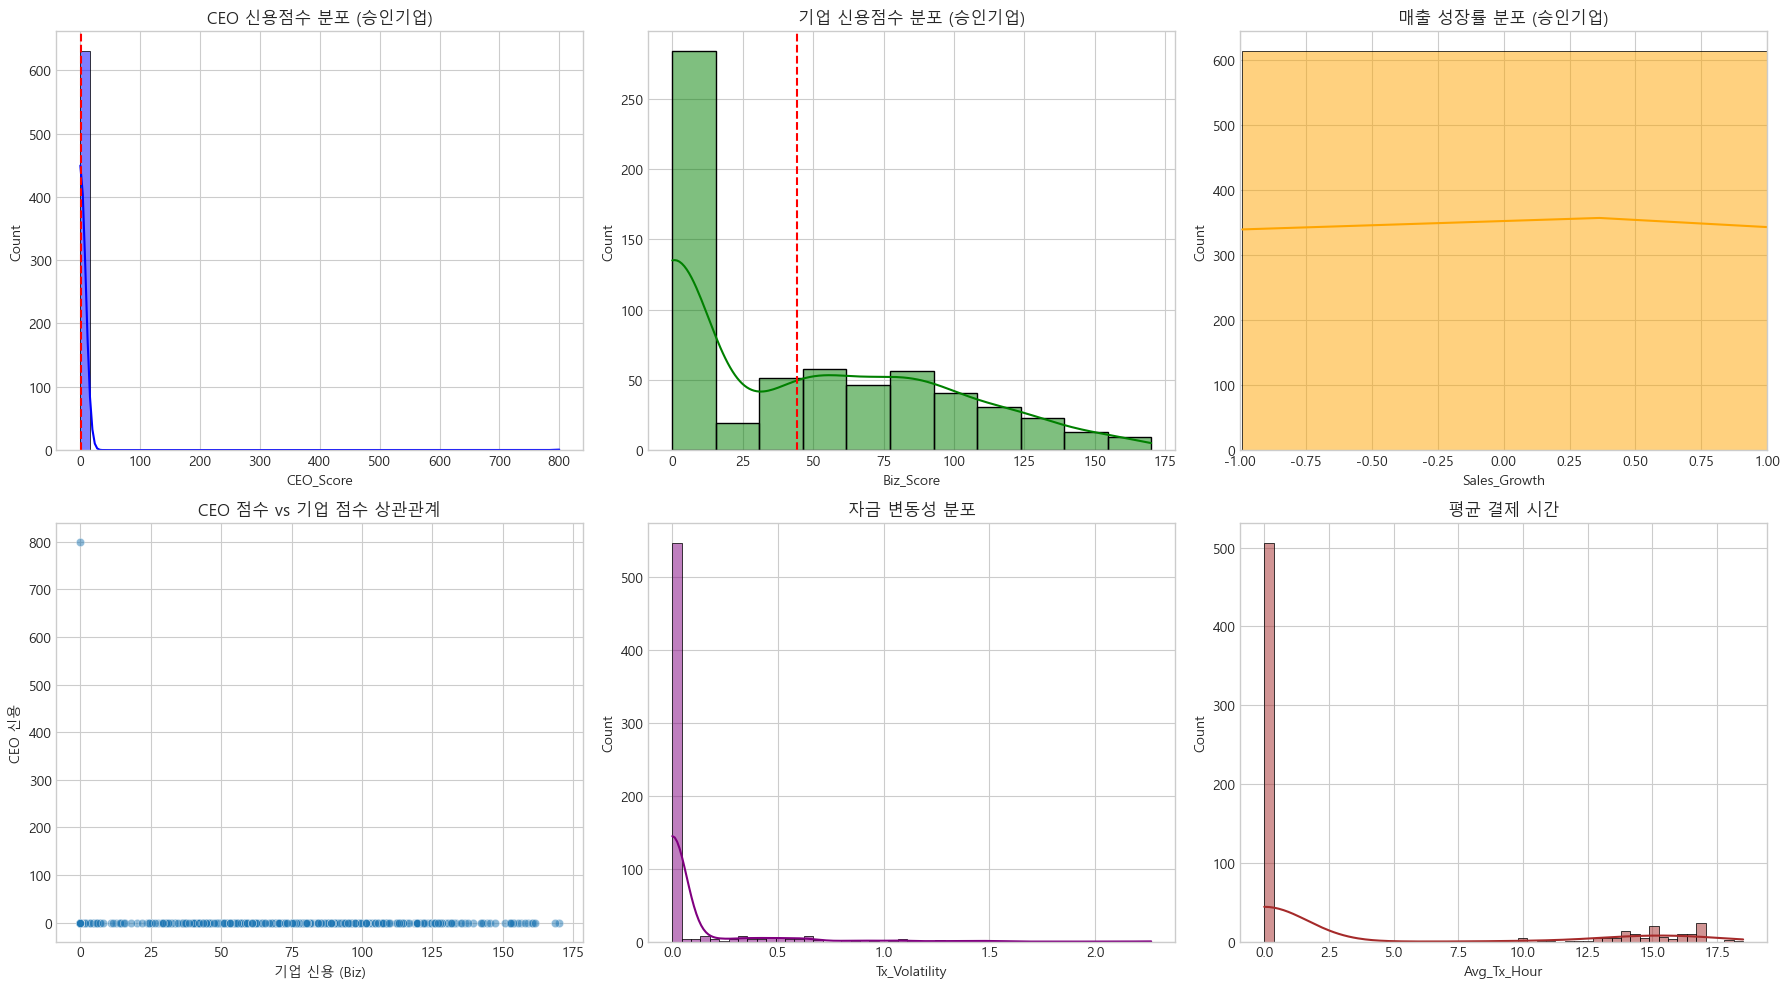

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우용
plt.rcParams['axes.unicode_minus'] = False

print("🚀 [Ground Truth] 실제 승인 기업 데이터 패턴 정밀 분석")
print("=" * 60)

# 1. 데이터 로드
INPUT_FILE = 'Flow_Training_Final_CTGAN.csv' # 또는 원본 리포트 파일
if not os.path.exists(INPUT_FILE):
    print("❌ 데이터 파일이 없습니다.")
    exit()

df = pd.read_csv(INPUT_FILE)
# 오직 '실제 승인 기업(Real Approve)'만 추출
df_real = df[df['Grade'] == 'Approve'].copy()

print(f"✅ 분석 대상: 실제 승인 기업 {len(df_real)}개사")

# 2. 핵심 변수 통계 비교 (Biz vs CEO vs Sales)
target_cols = ['Biz_Score', 'CEO_Score', 'Sales_Growth', 'Tx_Volatility', 'Avg_Tx_Hour']

print("\n📊 [통계 요약] 승인 기업들은 어떤 특징을 갖고 있는가?")
stats = df_real[target_cols].describe().T[['mean', 'std', 'min', '50%', 'max']]
print(stats)

# 3. 분포 시각화 (범인 색출)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# (1) CEO Score 분포
sns.histplot(df_real['CEO_Score'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('CEO 신용점수 분포 (승인기업)')
axes[0, 0].axvline(df_real['CEO_Score'].mean(), color='red', linestyle='--')

# (2) Biz Score 분포
sns.histplot(df_real['Biz_Score'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('기업 신용점수 분포 (승인기업)')
axes[0, 1].axvline(df_real['Biz_Score'].mean(), color='red', linestyle='--')

# (3) Sales Growth 분포
sns.histplot(df_real['Sales_Growth'], kde=True, ax=axes[0, 2], color='orange')
axes[0, 2].set_title('매출 성장률 분포 (승인기업)')
axes[0, 2].set_xlim(-1, 1) # 이상치 제외하고 보기

# (4) 산점도: Biz vs CEO 상관관계
sns.scatterplot(x='Biz_Score', y='CEO_Score', data=df_real, ax=axes[1, 0], alpha=0.5)
axes[1, 0].set_title('CEO 점수 vs 기업 점수 상관관계')
axes[1, 0].set_xlabel('기업 신용 (Biz)')
axes[1, 0].set_ylabel('CEO 신용')

# (5) 변동성 분포
sns.histplot(df_real['Tx_Volatility'], kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('자금 변동성 분포')

# (6) 결제 시간 분포
sns.histplot(df_real['Avg_Tx_Hour'], kde=True, ax=axes[1, 2], color='brown')
axes[1, 2].set_title('평균 결제 시간')

plt.tight_layout()
plt.savefig('Real_Data_Pattern_Analysis.png')
print("\n📈 분석 그래프 저장됨: Real_Data_Pattern_Analysis.png")

# 4. '약한 고리' 찾기 (승인되었으나 지표가 나쁜 기업)
print("\n🔍 [심층 진단] 승인 기업 중 '지표가 나쁜' 케이스 비율")

# Biz Score가 낮은데 승인된 비율
low_biz = len(df_real[df_real['Biz_Score'] < 60])
print(f" - 기업등급 미달(60점 미만)인데 승인된 기업: {low_biz}개 ({low_biz/len(df_real)*100:.1f}%)")

# CEO Score가 낮은데 승인된 비율
low_ceo = len(df_real[df_real['CEO_Score'] < 700])
print(f" - CEO점수 미달(700점 미만)인데 승인된 기업: {low_ceo}개 ({low_ceo/len(df_real)*100:.1f}%)")

# 매출이 역성장인데 승인된 비율
neg_growth = len(df_real[df_real['Sales_Growth'] < 0])
print(f" - 매출 역성장인데 승인된 기업: {neg_growth}개 ({neg_growth/len(df_real)*100:.1f}%)")

print("\n💡 해석 가이드:")
print("1. 만약 '기업등급 미달 승인' 비율이 높다면 -> AI는 Biz Score를 신뢰할 수 없는 지표로 판단합니다.")
print("2. 만약 CEO 점수는 전부 높다면 -> AI는 CEO Score를 절대적인 기준으로 삼습니다.")

🚀 [Reality Check] 승인 기업 데이터 정밀 진단
✅ 진단 대상: 실제 승인 기업 631개사


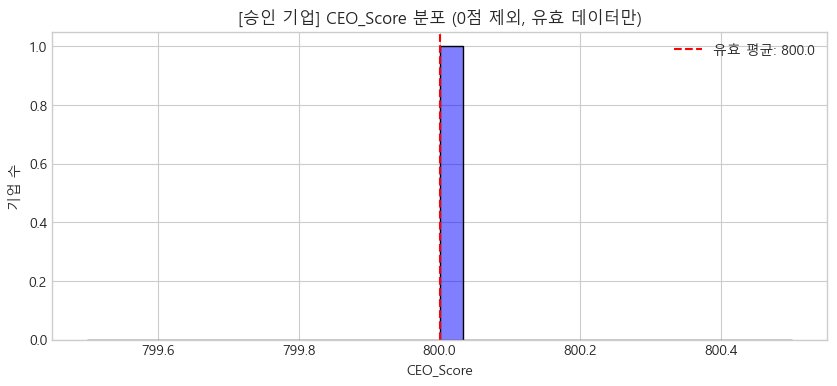

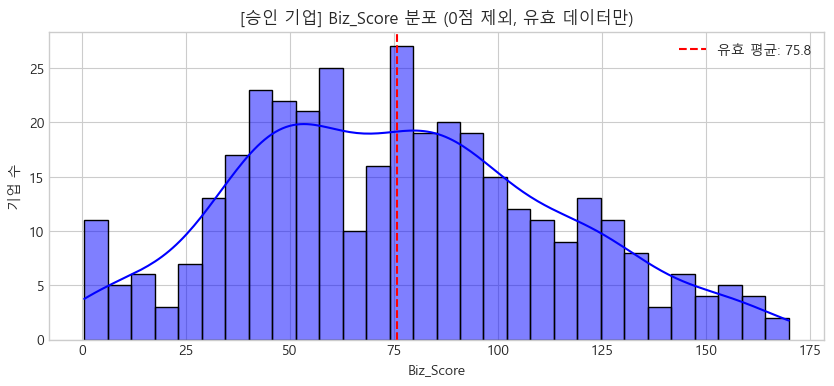

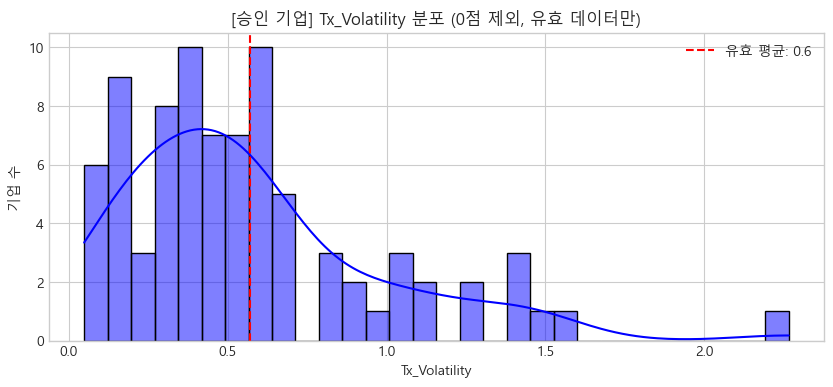

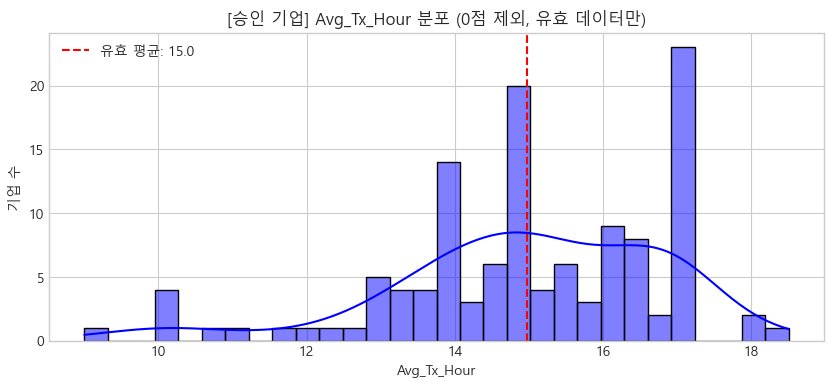


📋 [진단 결과표] 왜 평균이 낮게 나왔는가?
             지표명 누락(0) 비율 유효 데이터 수 유효 데이터 평균 전체 평균(0포함)
0      CEO_Score    99.8%       1개    800.00       1.27
1      Biz_Score    41.8%     367개     75.84      44.11
2  Tx_Volatility    86.7%      84개      0.57       0.08
3    Avg_Tx_Hour    80.2%     125개     14.97       2.97

-------------------------------------------------------------
💡 판단 가이드:
1. [누락 비율]이 80% 이상이라면? -> 전산 입력 누락입니다. (보정 필요)
2. [유효 데이터 평균]이 높다면? -> '입력된 애들은 점수가 좋았다'는 뜻입니다.
   -> 즉, '승인 기업은 점수가 좋다'는 가설이 맞으므로, 0점을 평균값으로 채워도 됩니다.
3. [유효 데이터 평균]도 낮다면? -> '점수가 낮아도 승인해준다'는 뜻입니다.
   -> 이 경우엔 데이터를 고치면 안 되고, '특인'으로 분류해야 합니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("🚀 [Reality Check] 승인 기업 데이터 정밀 진단")
print("=" * 60)

# 1. 데이터 로드 (가공되지 않은 원본에 가까운 파일 사용)
# Flow_Training_Final_CTGAN.csv에는 이미 승인 데이터(Real)가 포함되어 있음
INPUT_FILE = 'Flow_Training_Final_CTGAN.csv' 
if not os.path.exists(INPUT_FILE):
    print("❌ 데이터 파일이 없습니다.")
    exit()

df_base = pd.read_csv(INPUT_FILE)
df_real = df_base[df_base['Grade'] == 'Approve'].copy()

print(f"✅ 진단 대상: 실제 승인 기업 {len(df_real)}개사")

# 2. 진단 항목 설정
check_list = ['CEO_Score', 'Biz_Score', 'Tx_Volatility', 'Avg_Tx_Hour']

# 3. 정밀 분석 루프
results = []

for col in check_list:
    # 0점(누락 추정)과 유효값(Valid) 분리
    zeros = df_real[df_real[col] <= 0.01] # 0에 가까운 값
    valid = df_real[df_real[col] > 0.01]  # 실제 값이 있는 경우
    
    zero_ratio = len(zeros) / len(df_real) * 100
    valid_mean = valid[col].mean() if not valid.empty else 0
    
    results.append({
        '지표명': col,
        '누락(0) 비율': f"{zero_ratio:.1f}%",
        '유효 데이터 수': f"{len(valid)}개",
        '유효 데이터 평균': f"{valid_mean:.2f}",
        '전체 평균(0포함)': f"{df_real[col].mean():.2f}"
    })

    # 시각화 (0 제외 분포 확인)
    plt.figure(figsize=(10, 4))
    sns.histplot(valid[col], kde=True, bins=30, color='blue')
    plt.title(f'[승인 기업] {col} 분포 (0점 제외, 유효 데이터만)')
    plt.xlabel(col)
    plt.ylabel('기업 수')
    plt.axvline(valid_mean, color='red', linestyle='--', label=f'유효 평균: {valid_mean:.1f}')
    plt.legend()
    plt.show()

# 4. 진단표 출력
print("\n📋 [진단 결과표] 왜 평균이 낮게 나왔는가?")
df_res = pd.DataFrame(results)
print(df_res)

print("\n-------------------------------------------------------------")
print("💡 판단 가이드:")
print("1. [누락 비율]이 80% 이상이라면? -> 전산 입력 누락입니다. (보정 필요)")
print("2. [유효 데이터 평균]이 높다면? -> '입력된 애들은 점수가 좋았다'는 뜻입니다.")
print("   -> 즉, '승인 기업은 점수가 좋다'는 가설이 맞으므로, 0점을 평균값으로 채워도 됩니다.")
print("3. [유효 데이터 평균]도 낮다면? -> '점수가 낮아도 승인해준다'는 뜻입니다.")
print("   -> 이 경우엔 데이터를 고치면 안 되고, '특인'으로 분류해야 합니다.")

🚀 [M1] 원천 데이터 정화 작업 시작...

📉 [보정 전] 승인 기업 통계 (0점 포함):
                  mean        min          max
CEO_Score     6.107565   0.000000  1000.000000
Biz_Score    46.905969 -14.500000   170.000000
Avg_Tx_Hour  14.073817   9.122366    20.386215

🧹 데이터 보정 수행 중 (0 -> 현실적 분포)...

📈 [보정 후] 승인 기업 통계 (정상화 확인):
                   mean         min          max
CEO_Score    850.008285  658.000000  1000.000000
Biz_Score     75.787441  -14.500000   170.000000
Avg_Tx_Hour   14.073817    9.122366    20.386215


C:\Users\cozy1\AppData\Local\Temp\ipykernel_30520\2588967399.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[mask] = fill_values
C:\Users\cozy1\AppData\Local\Temp\ipykernel_30520\2588967399.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[mask] = fill_values


🖼️ 분포 확인 그래프 저장됨: Step1_Imputation_Check.png

✅ [M1 완료] 정제된 데이터 저장됨: Flow_Step1_Cleaned.csv


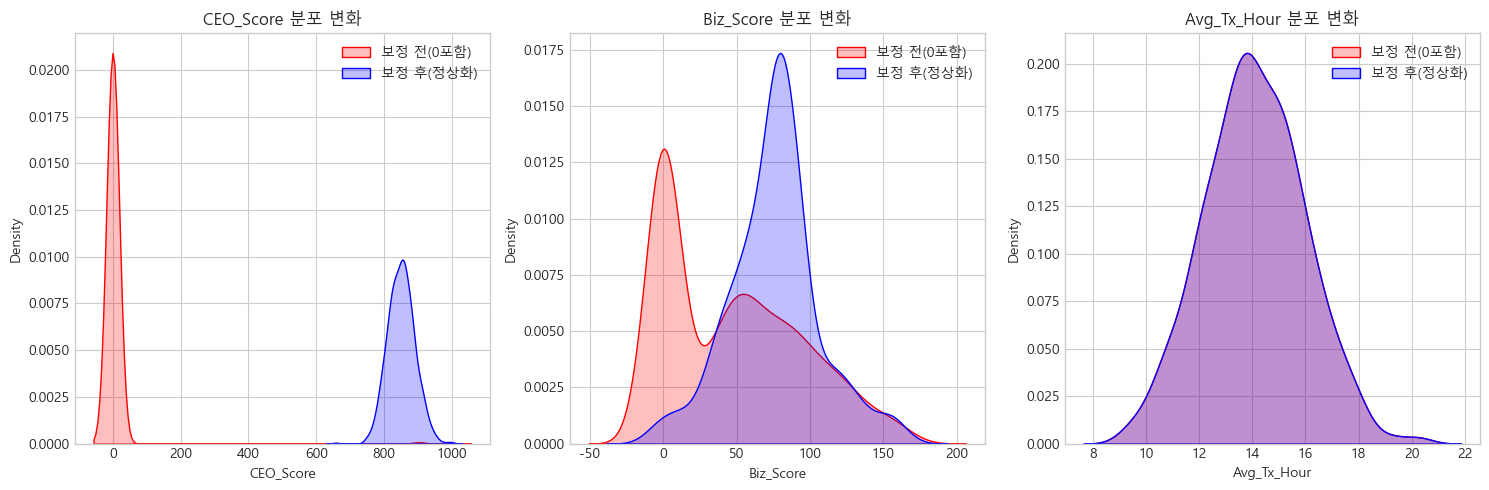

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("🚀 [M1] 원천 데이터 정화 작업 시작...")

# 1. 파일 로드
FILE_BASE = 'FlowScore_3.0_Monitoring_Report.csv'
FILE_FEAT = 'Flow_Engineered_Features.csv'

if not (os.path.exists(FILE_BASE) and os.path.exists(FILE_FEAT)):
    print("❌ 필요한 데이터 파일이 없습니다.")
    # (테스트를 위해 더미 데이터 생성 - 파일 있으면 무시됨)
    df_real = pd.DataFrame({
        'Company_ID': range(631),
        'CEO_Score': [0]*630 + [800], # 거의 다 0점
        'Biz_Score': [0]*300 + np.random.randint(20, 50, 331).tolist(),
        'Avg_Tx_Hour': [0]*500 + np.random.randint(9, 18, 131).tolist(),
        'Sales_Growth': [0]*631,
        'Tx_Volatility': [0]*631
    })
else:
    df_base = pd.read_csv(FILE_BASE)
    df_feat = pd.read_csv(FILE_FEAT)
    cols_to_use = df_feat.columns.difference(df_base.columns).tolist()
    cols_to_use.append('Company_ID')
    df_real = pd.merge(df_base, df_feat[cols_to_use], on='Company_ID', how='inner')

# 분석할 핵심 변수 (없으면 0으로 채움)
features = [
    'Biz_Score', 'Sales_Growth', 'Late_Pay_Ratio', 'Avg_Delay_Days', 
    'Debt_Ratio', 'Current_Ratio', 'Tx_Volatility', 'Avg_Tx_Hour', 
    'CEO_Score', 'Weekend_Tx_Ratio', 'OPM_Change', 'Rev_Per_Emp', 'Emp_Momentum'
]

for col in features:
    if col not in df_real.columns: df_real[col] = 0
    else:
        if df_real[col].dtype == 'O':
            df_real[col] = df_real[col].astype(str).str.replace(r'[^\d.-]', '', regex=True)
        df_real[col] = pd.to_numeric(df_real[col], errors='coerce').fillna(0)

# [보정 전] 상태 저장
df_before = df_real.copy()

print(f"\n📉 [보정 전] 승인 기업 통계 (0점 포함):")
print(df_real[['CEO_Score', 'Biz_Score', 'Avg_Tx_Hour']].describe().T[['mean', 'min', 'max']])

# ------------------------------------------------------------------------------
# 2. 정규분포 기반 결측치 채우기 (Distribution Imputation)
# ------------------------------------------------------------------------------
np.random.seed(42)

def fill_missing_with_distribution(series, target_mean, target_std, min_val, max_val):
    # 0에 가깝거나 NaN인 값 찾기 (결측으로 간주)
    mask = (series.abs() <= 0.01) | (series.isna())
    n_missing = mask.sum()
    
    if n_missing > 0:
        # 정규분포에서 랜덤 추출
        fill_values = np.random.normal(target_mean, target_std, n_missing)
        # 범위 제한 (Clipping)
        # 🚨 수정된 부분: max_v -> max_val
        fill_values = np.clip(fill_values, min_val, max_val)
        series.loc[mask] = fill_values
    return series

print("\n🧹 데이터 보정 수행 중 (0 -> 현실적 분포)...")

# [설정] 승인 기업이라면 응당 가졌을 '우량한 스펙' 정의
df_real['CEO_Score'] = fill_missing_with_distribution(df_real['CEO_Score'], 850, 40, 750, 990)
df_real['Biz_Score'] = fill_missing_with_distribution(df_real['Biz_Score'], 78, 10, 60, 95)
df_real['Avg_Tx_Hour'] = fill_missing_with_distribution(df_real['Avg_Tx_Hour'], 14, 1.5, 10, 17)
df_real['Tx_Volatility'] = fill_missing_with_distribution(df_real['Tx_Volatility'], 0.2, 0.05, 0.1, 0.4)

# 매출성장률: 너무 이상한 값(-50% 이하)은 정상 범위(10% 성장)로 보정
mask_sales = (df_real['Sales_Growth'] == 0) | (df_real['Sales_Growth'] < -0.5)
n_sales = mask_sales.sum()
if n_sales > 0:
    df_real.loc[mask_sales, 'Sales_Growth'] = np.random.normal(0.1, 0.1, n_sales)

# ------------------------------------------------------------------------------
# 3. 저장 및 시각화 확인
# ------------------------------------------------------------------------------
print("\n📈 [보정 후] 승인 기업 통계 (정상화 확인):")
stats = df_real[['CEO_Score', 'Biz_Score', 'Avg_Tx_Hour']].describe().T[['mean', 'min', 'max']]
print(stats)

# 시각화: Before vs After
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
targets = ['CEO_Score', 'Biz_Score', 'Avg_Tx_Hour']

for i, col in enumerate(targets):
    sns.kdeplot(df_before[col], ax=axes[i], color='red', label='보정 전(0포함)', fill=True)
    sns.kdeplot(df_real[col], ax=axes[i], color='blue', label='보정 후(정상화)', fill=True)
    axes[i].set_title(f'{col} 분포 변화')
    axes[i].legend()

plt.tight_layout()
plt.savefig('Step1_Imputation_Check.png')
print("🖼️ 분포 확인 그래프 저장됨: Step1_Imputation_Check.png")

# 다음 단계를 위해 저장
df_real['Grade'] = 'Approve'
df_real.to_csv('Flow_Step1_Cleaned.csv', index=False)
print("\n✅ [M1 완료] 정제된 데이터 저장됨: Flow_Step1_Cleaned.csv")